Created on Tue Nov  7 16:59:14 2023

@author: Santiago D'hers

Use:

- This script will train AI models to identify exploration using mouse and object position

Requirements:

- The position.csv files processed by 1-Manage_H5.py
- Labeled data for the position files (to train the model)

or

- Access to the file colabeled_data.csv, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

In [133]:
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
import datetime

import joblib

# from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, Attention, Dropout, LayerNormalization, BatchNormalization, Lambda, GlobalMaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import Model
# from tensorflow.keras.regularizers import l2

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [65]:
models_folder = 'C:/Users/dhers/Desktop/STORM/docs/models'

colabels_file = os.path.join(models_folder, 'colabels.csv')
colabels = pd.read_csv(colabels_file)

objects = ['obj']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']

past, future = 5, 5 # if you use a LSTM model, you can set the window size here
broaden = 2 # using the same amount of frames, set how broad the window is (skipping frames)
frames = list(range(-past, future + 1))
broad_frames = [-int(abs(x) ** broaden) if x < 0 else int(x ** broaden) for x in frames]
print(f'LSTM frame window: {broad_frames}')

train_with_average = True # If False, it trains with all the labels separately
make_discrete = False # If False, labels are float (not 0 and 1)
save_data = True # if True, the data processed will be saved with today's date

use_saved_data = False # if True, we use the dataframe processed previously
if use_saved_data:
    saved_data = r'c:\Users\dhers\Desktop\STORM\docs\models\training_data\training_data_best.h5' # Select the data you want to rescue

# Get the start time
start_time = datetime.datetime.now()

LSTM frame window: [-25, -16, -9, -4, -1, 0, 1, 4, 9, 16, 25]


In [3]:
def prepare_positions_and_labels(colabels, train_with_average = True):

    # The labels for left and right exploration are on the rest of the columns, we need to extract them
    position = colabels.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy()
                            
    lblr_A = colabels.filter(regex='Marian').copy()
    lblr_B = colabels.filter(regex='Agus').copy()
    lblr_C = colabels.filter(regex='Santi').copy()
    lblr_D = colabels.filter(regex='Guille').copy()
    lblr_E = colabels.filter(regex='Myself').copy()

    labelers = [lblr_A, lblr_B, lblr_C, lblr_D, lblr_E]

    if train_with_average:
        # Concatenate the dataframes along the columns axis (axis=1) and calculate the mean of each row
        combined_df = pd.concat(labelers, axis=1)
        avrg = pd.DataFrame(combined_df.mean(axis=1), columns=['mean'])

        # Apply median filter
        avrg['med_filt'] = signal.medfilt(avrg['mean'], kernel_size = 3)

        # Gaussian kernel
        gauss_kernel = signal.windows.gaussian(3, 0.6)
        gauss_kernel = gauss_kernel / sum(gauss_kernel)

        # Pad the median filtered data to mitigate edge effects
        pad_width = (len(gauss_kernel) - 1) // 2
        padded = np.pad(avrg['med_filt'], pad_width, mode='edge')

        # Apply convolution
        smooth = signal.convolve(padded, gauss_kernel, mode='valid')

        # Trim the padded edges to restore original length
        avrg['smooth'] = smooth[:len(avrg['mean'])]

        # Apply sigmoid function to keep values between 0 and 1
        avrg['labels'] = round(1 / (1 + np.exp(-12*(avrg['smooth']-0.5))), 2)

        ready_data = pd.concat([position, avrg['labels']], axis = 1)

    else:
        # Join position with all the labels separately
        concatenated_position = pd.concat([position] * len(labelers), ignore_index=True)
        concatenated_labelers = pd.concat(labelers, ignore_index=True)
        ready_data = pd.concat([concatenated_position, concatenated_labelers], axis = 1)

    return ready_data, labelers

# Prepare the data
ready_data, labelers = prepare_positions_and_labels(colabels)

In [4]:
def recenter(df: pd.DataFrame, point: str, bodyparts: list) -> pd.DataFrame:
    """Recenters a DataFrame around a specified point.

    Args:
        df (pd.DataFrame): DataFrame to be recentered.
        point (str): Name of the point to be used as the center.
        bodyparts (list): List of bodyparts to be recentered.

    Returns:
        pd.DataFrame: Recentered DataFrame.
    """
    # Create a copy of the original dataframe
    df_copy = df.copy()
    bodypart_columns = []
    
    for bodypart in bodyparts:
        # Subtract point_x from columns ending in _x
        x_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_x')]
        df_copy[x_cols] = df_copy[x_cols].apply(lambda col: col - df_copy[f'{point}_x'])
        
        # Subtract point_y from columns ending in _y
        y_cols = [col for col in df_copy.columns if col.endswith(f'{bodypart}_y')]
        df_copy[y_cols] = df_copy[y_cols].apply(lambda col: col - df_copy[f'{point}_y'])
        
        # Collect bodypart columns
        bodypart_columns.extend(x_cols)
        bodypart_columns.extend(y_cols)
        
    return df_copy[bodypart_columns]


def reshape(df: pd.DataFrame, past: int = 3, future: int = 3, broaden: float = 1.7) -> np.ndarray:
    """Reshapes a DataFrame into a 3D NumPy array.

    Args:
        df (pd.DataFrame): DataFrame to reshape.
        past (int, optional): Number of past frames to include. Defaults to 3.
        future (int, optional): Number of future frames to include. Defaults to 3.
        broaden (float, optional): Factor to broaden the range of frames. Defaults to 1.7.

    Returns:
        np.ndarray: 3D NumPy array with shape (past + future + 1, past + future + 1, 2).
    """

    reshaped_df = []
    
    frames = list(range(-past, future + 1))

    if broaden > 1:
        frames = [-int(abs(x) ** broaden) if x < 0 else int(x ** broaden) for x in frames]

    # Iterate over each row index in the DataFrame
    for i in range(len(df)):
        # Determine which indices to include for reshaping
        indices_to_include = sorted([
            max(0, i - frame) if frame > 0 else min(len(df) - 1, i - frame)
            for frame in frames
        ])
        
        # Append the rows using the calculated indices
        reshaped_df.append(df.iloc[indices_to_include].to_numpy())
    
    # Convert the list to a 3D NumPy array
    reshaped_array = np.array(reshaped_df)
    
    return reshaped_array


def focus(df, column_to_filter = 'labels', distance = 25):

    # Extract the column of interest
    column_of_interest = df.loc[:, column_to_filter]

    print(f'Starting with {len(column_of_interest)} rows')

    # Find the indices of the non-zero rows in the column
    non_zero_indices = column_of_interest[column_of_interest > 0.05].index

    # Create a boolean mask to keep rows that are within 'distance' rows of a non-zero row
    mask = pd.Series(False, index=df.index)

    for idx in non_zero_indices:
        # Mark rows within 'distance' rows before and after the non-zero row
        lower_bound = max(0, idx - distance)
        upper_bound = min(len(df) - 1, idx + distance)
        mask[lower_bound:upper_bound + 1] = True

    # Filter the dataframe using the mask
    df_filtered = df[mask]

    # Optional: Reset index if you want a clean dataframe without gaps in the indices
    df_filtered.reset_index(drop=True, inplace=True)
    
    print(f"Reduced to {len(df_filtered)} rows. Number of exploration rows: {len(non_zero_indices)}")

    return df_filtered

In [5]:
ready_data_focus = focus(ready_data, distance = 25)

Starting with 167012 rows
Reduced to 37595 rows. Number of exploration rows: 12885


In [6]:
def prepare_training_data(df, obj = 'obj', bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body'], y_col = 'labels'):
    
    # Group the DataFrame by the values in the first column
    groups = df.groupby(df[f'{obj}_x'])
    
    # Split the DataFrame into multiple DataFrames and labels
    final_dataframes = {}
    wide_dataframes = {}
    
    for category, group in groups:

        recentered_data = recenter(group, obj, bodyparts)
        labels = group[f'{y_col}']

        final_dataframes[category] = {'position': recentered_data, 'labels': labels}

        reshaped_data = reshape(recentered_data)
        wide_dataframes[category] = {'position': reshaped_data, 'labels': labels}
        
    # Get a list of the keys (categories)
    keys = list(wide_dataframes.keys())
    
    # Shuffle the keys
    np.random.shuffle(keys)
    
    # Calculate the lengths for each part
    len_val = len(keys) * 15 // 100
    len_test = len(keys) * 15 // 100
    
    # Use slicing to divide the list
    val_keys = keys[:len_val]
    test_keys = keys[len_val:(len_val + len_test)]
    train_keys = keys[(len_val + len_test):]
    
    # Initialize empty lists to collect dataframes
    X_train_wide = []
    X_test_wide = []
    X_val_wide = []

    X_train = []
    X_test = []
    X_val = []

    y_train = []
    y_test = []
    y_val = []
    
    # first the simple data 
    for key in train_keys:
        X_train_wide.append(wide_dataframes[key]['position'])
        X_train.append(final_dataframes[key]['position'])
        y_train.append(final_dataframes[key]['labels'])
    for key in test_keys:
        X_test_wide.append(wide_dataframes[key]['position'])
        X_test.append(final_dataframes[key]['position'])
        y_test.append(final_dataframes[key]['labels'])
    for key in val_keys:
        X_val_wide.append(wide_dataframes[key]['position'])
        X_val.append(final_dataframes[key]['position'])
        y_val.append(final_dataframes[key]['labels'])
    
    X_train_wide = np.concatenate(X_train_wide, axis=0)
    X_test_wide = np.concatenate(X_test_wide, axis=0)
    X_val_wide = np.concatenate(X_val_wide, axis=0)

    X_train = np.concatenate(X_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    X_val = np.concatenate(X_val, axis=0)
        
    y_train = np.concatenate(y_train, axis=0)
    y_test = np.concatenate(y_test, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    
    return X_train_wide, X_train, y_train, X_test_wide, X_test, y_test, X_val_wide, X_val, y_val

In [7]:
if use_saved_data:
    # Load arrays
    with h5py.File(saved_data, 'r') as hf:
        X_test = hf['X_test'][:]
        y_test = hf['y_test'][:]
        X_val = hf['X_val'][:]
        y_val = hf['y_val'][:]
        X_train = hf['X_train'][:]
        y_train = hf['y_train'][:]
        X_test_wide = hf['X_test_wide'][:]
        X_val_wide = hf['X_val_wide'][:]
        X_train_wide = hf['X_train_wide'][:]
        
    print("Data is ready to train")

else:
    X_train_wide, X_train, y_train, X_test_wide, X_test, y_test, X_val_wide, X_val, y_val = prepare_training_data(ready_data_focus)
    
    # Print the sizes of each set
    print(f"Training set size: {len(X_train)} samples")
    print(f"Validation set size: {len(X_val)} samples")
    print(f"Testing set size: {len(X_test)} samples")
    print(f"Total samples: {len(X_train)+len(X_val)+len(X_test)}")

    if save_data:
        # Save arrays
        with h5py.File(os.path.join(models_folder, f'training_data/training_data_{start_time.date()}.h5'), 'w') as hf:
            hf.create_dataset('X_test', data=X_test)
            hf.create_dataset('y_test', data=y_test)
            hf.create_dataset('X_val', data=X_val)
            hf.create_dataset('y_val', data=y_val)
            hf.create_dataset('X_train', data=X_train)
            hf.create_dataset('y_train', data=y_train)
            hf.create_dataset('X_test_wide', data=X_test_wide)
            hf.create_dataset('X_val_wide', data=X_val_wide)
            hf.create_dataset('X_train_wide', data=X_train_wide)
            
            print(f'Saved data to training_data_{start_time.date()}.h5')

Training set size: 27403 samples
Validation set size: 5240 samples
Testing set size: 4952 samples
Total samples: 37595
Saved data to training_data_2024-11-21.h5


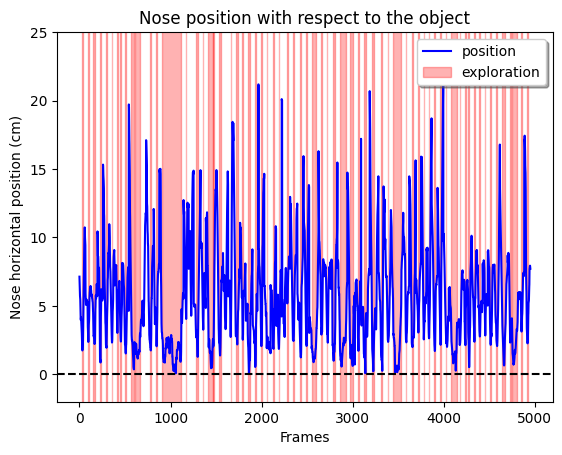

In [8]:
def plot_example_data(X, y):
    # Select data to plot
    position = np.sqrt(X[:,0]**2 + X[:,1]**2).copy()
    exploration = y.copy()

    # Plotting position
    plt.plot(position, label='position', color='blue')

    # Shading exploration regions
    plt.fill_between(range(len(exploration)), -30, 30, where = exploration > 0.5, label = 'exploration', color='red', alpha=0.3)

    # Adding labels
    plt.xlabel('Frames')
    plt.ylabel('Nose horizontal position (cm)')
    plt.legend(loc='upper right', fancybox=True, shadow=True, framealpha=1.0)
    plt.title('Nose position with respect to the object')
    plt.axhline(y=0, color='black', linestyle='--')

    # Zoom in on some frames
    # plt.xlim((1000, 2500))
    plt.ylim((-2, 25))

    plt.show()

# Plot the data before training
plot_example_data(X_test, y_test)

Lets get some tools ready for model training:

- Early stopping
- Scheduled learning rate

In [9]:
# Set the number of neurons in each layer

param_H4 = 32
param_H3 = 24
param_H2 = 16
param_H1 = 12
param_H0 = 8

batch_size = 32 # Set the batch size
lr = 0.00016 # Set the initial learning rate
epochs = 80 # Set the training epochs
patience = 8 # Set the wait for the early stopping mechanism

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    mode='min',
    verbose=1,
)

# Define a learning rate schedule function
initial_lr = lr # Set the initial lr
def lr_schedule(epoch, lr): # Define a learning rate schedule function
    initial_lr = lr  # Initial learning rate
    decay_factor = 0.9  # Learning rate decay factor
    decay_epochs = 6   # Number of epochs after which to decay the learning rate

    # Calculate the new learning rate
    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))

    return lr

# Define the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [11]:
def plot_history(model, model_name):
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(model.history['loss'], label='Training loss')
    plt.plot(model.history['val_loss'], label='Validation loss')
    plt.plot(model.history['accuracy'], label='Training accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation accuracy')
    
    plt.title(f'Training of model {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('%')
    plt.legend()
    plt.show()

In [12]:
def evaluate(X, y, model):
    
    # Evaluate the model on the testing set
    y_pred = model.predict(X)
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    y_binary = (y > 0.5).astype(int) # Convert average labels to binary labels
    
    accuracy = accuracy_score(y_binary, y_pred_binary)
    precision = precision_score(y_binary, y_pred_binary, average = 'weighted')
    recall = recall_score(y_binary, y_pred_binary, average = 'weighted')
    f1 = f1_score(y_binary, y_pred_binary, average = 'weighted')
    
    print(classification_report(y_binary, y_pred_binary))
    
    return accuracy, precision, recall, f1

def evaluate_continuous(X, y, model):
    # Ensure X and y are on the same device
    if isinstance(X, tf.Tensor):
        if '/GPU:' in X.device:
            y = tf.convert_to_tensor(y)
            y = tf.identity(y)

    # Evaluate the model on the testing set
    y_pred = model.predict(X)

    # Convert y and y_pred to numpy arrays if they are tensors
    if isinstance(y_pred, tf.Tensor):
        y_pred = y_pred.numpy()
    
    if isinstance(y, tf.Tensor):
        y = y.numpy()
    
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return mse, mae, r2

Now we train the first model

In [ ]:
# Build a simple neural network
model_simple = tf.keras.Sequential([
    Input(shape=(X_train.shape[1],)),

    Dense(param_H4, activation='relu'),
    LayerNormalization(),
    Dropout(0.2),
    Dense(param_H3, activation='relu'),
    LayerNormalization(),
    Dropout(0.2),
    Dense(param_H2, activation='relu'),
    LayerNormalization(),
    Dropout(0.2),
    Dense(param_H1, activation='relu'),
    LayerNormalization(),
    Dropout(0.2),
    Dense(param_H0, activation='relu'),
    
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model_simple.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                416       
                                                                 
 layer_normalization_4 (Laye  (None, 32)               64        
 rNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 24)                792       
                                                                 
 layer_normalization_5 (Laye  (None, 24)               48        
 rNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 24)               

In [20]:
# Train the model
history_simple = model_simple.fit(X_train, y_train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping, lr_scheduler])

Epoch 1/80
857/857 [==============================] - 9s 10ms/step - loss: 0.3609 - accuracy: 0.6631 - val_loss: 0.3331 - val_accuracy: 0.6660 - lr: 7.6528e-05
Epoch 2/80
857/857 [==============================] - 8s 9ms/step - loss: 0.3590 - accuracy: 0.6646 - val_loss: 0.3376 - val_accuracy: 0.6668 - lr: 7.6528e-05
Epoch 3/80
857/857 [==============================] - 8s 9ms/step - loss: 0.3536 - accuracy: 0.6673 - val_loss: 0.3378 - val_accuracy: 0.6658 - lr: 7.6528e-05
Epoch 4/80
857/857 [==============================] - 8s 9ms/step - loss: 0.3487 - accuracy: 0.6708 - val_loss: 0.3331 - val_accuracy: 0.6693 - lr: 7.6528e-05
Epoch 5/80
857/857 [==============================] - 6s 7ms/step - loss: 0.3470 - accuracy: 0.6728 - val_loss: 0.3353 - val_accuracy: 0.6664 - lr: 7.6528e-05
Epoch 6/80
857/857 [==============================] - 8s 10ms/step - loss: 0.3452 - accuracy: 0.6717 - val_loss: 0.3306 - val_accuracy: 0.6643 - lr: 6.8875e-05
Epoch 7/80
857/857 [========================

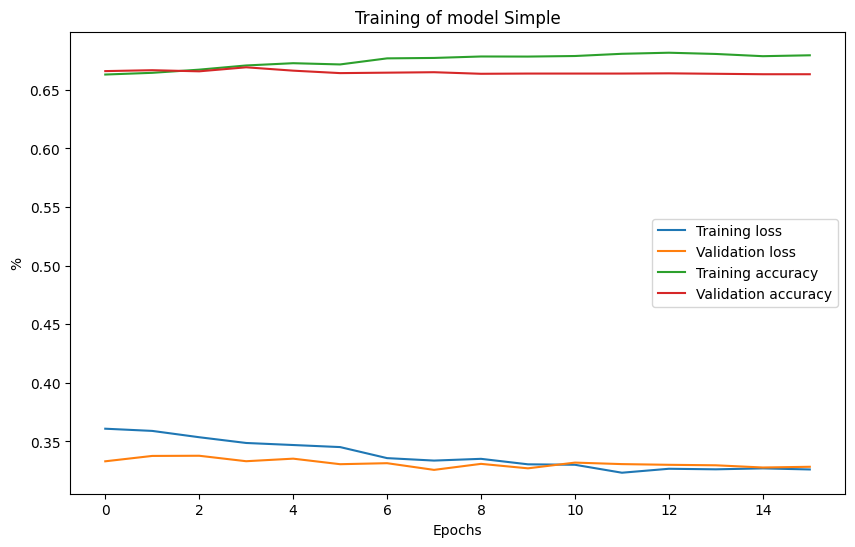

In [21]:
# Plot the training and validation loss
plot_history(history_simple, "Simple")

In [22]:
# Calculate accuracy and precision of the model
accuracy_simple, precision_simple, recall_simple, f1_simple = evaluate(X_test, y_test, model_simple)
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")

mse_simple, mae_simple, r2_simple = evaluate_continuous(X_test, y_test, model_simple)
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")

155/155 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3650
           1       0.82      0.92      0.87      1302

    accuracy                           0.93      4952
   macro avg       0.90      0.92      0.91      4952
weighted avg       0.93      0.93      0.93      4952

Accuracy = 0.9265, Precision = 0.9309, Recall = 0.9265, F1 Score = 0.9277 -> simple
155/155 [==============================] - 0s 2ms/step
MSE = 0.0395, MAE = 0.1175, R-squared = 0.7753 -> simple


In [23]:
# Save the model
model_simple.save(os.path.join(models_folder, f'simple/model_simple_{start_time.date()}.keras'))

Lets move onto training a Recursive Network (that can see sequences)

In [ ]:
# Define the LSTM model
model_wide = tf.keras.Sequential([
    Input(shape=(X_train_wide.shape[1], X_train_wide.shape[2])),

    LSTM(param_H4, return_sequences=True),
    LayerNormalization(),
    Dropout(0.2),
    LSTM(param_H3, return_sequences=True),
    LayerNormalization(),
    Dropout(0.2),
    LSTM(param_H2, return_sequences=True),
    LayerNormalization(),
    Dropout(0.2),
    LSTM(param_H1, return_sequences=True),
    LayerNormalization(),
    Dropout(0.2),
    LSTM(param_H0, return_sequences=False),

    Dense(1, activation='sigmoid')
])

# Compile the model
model_wide.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model_wide.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 7, 32)             5760      
                                                                 
 layer_normalization_12 (Lay  (None, 7, 32)            64        
 erNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 7, 32)             0         
                                                                 
 lstm_6 (LSTM)               (None, 7, 24)             5472      
                                                                 
 layer_normalization_13 (Lay  (None, 7, 24)            48        
 erNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 7, 24)            

In [26]:
# Train the model
history_wide = model_wide.fit(X_train_wide, y_train,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_wide, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/80
857/857 [==============================] - 24s 23ms/step - loss: 0.5066 - accuracy: 0.5938 - val_loss: 0.4172 - val_accuracy: 0.6387 - lr: 1.6000e-04
Epoch 2/80
857/857 [==============================] - 18s 21ms/step - loss: 0.3595 - accuracy: 0.6676 - val_loss: 0.3998 - val_accuracy: 0.6468 - lr: 1.6000e-04
Epoch 3/80
857/857 [==============================] - 18s 21ms/step - loss: 0.3170 - accuracy: 0.6837 - val_loss: 0.3723 - val_accuracy: 0.6580 - lr: 1.6000e-04
Epoch 4/80
857/857 [==============================] - 18s 21ms/step - loss: 0.2998 - accuracy: 0.6887 - val_loss: 0.3635 - val_accuracy: 0.6592 - lr: 1.6000e-04
Epoch 5/80
857/857 [==============================] - 18s 21ms/step - loss: 0.2754 - accuracy: 0.6955 - val_loss: 0.3529 - val_accuracy: 0.6628 - lr: 1.6000e-04
Epoch 6/80
857/857 [==============================] - 18s 21ms/step - loss: 0.2633 - accuracy: 0.6989 - val_loss: 0.3191 - val_accuracy: 0.6685 - lr: 1.4400e-04
Epoch 7/80
857/857 [==============

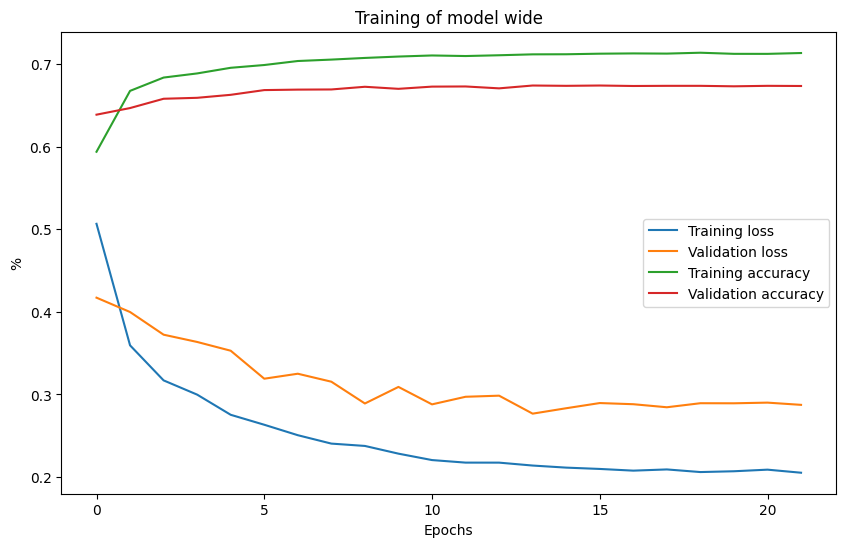

In [27]:
# Plot the training and validation loss
plot_history(history_wide, "wide")

In [28]:
# Calculate accuracy and precision of the model
accuracy_wide, precision_wide, recall_wide, f1_wide = evaluate(X_test_wide, y_test, model_wide)
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")

mse_wide, mae_wide, r2_wide = evaluate_continuous(X_test_wide, y_test, model_wide)
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

155/155 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      3650
           1       0.84      0.90      0.87      1302

    accuracy                           0.93      4952
   macro avg       0.90      0.92      0.91      4952
weighted avg       0.93      0.93      0.93      4952

Accuracy = 0.9283, Precision = 0.9311, Recall = 0.9283, F1 Score = 0.9292 -> wide
155/155 [==============================] - 1s 8ms/step
MSE = 0.0417, MAE = 0.0906, R-squared = 0.7625 -> wide


In [29]:
# Save the model
model_wide.save(os.path.join(models_folder, f'wide/model_wide_{start_time.date()}.keras'))

In [ ]:
# Define the sequential LSTM model
model_seq = tf.keras.Sequential([
    Input(shape=(X_train_wide.shape[1], X_train_wide.shape[2])),

    Bidirectional(LSTM(param_H4, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(param_H3, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(param_H2, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(param_H1, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(param_H0, return_sequences=False)),
    
    Dense(1, activation='sigmoid')
])

# Compile the model
model_seq.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                     loss='binary_crossentropy', metrics=['accuracy'])


In [31]:
model_seq.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 7, 64)            11520     
 nal)                                                            
                                                                 
 layer_normalization_17 (Lay  (None, 7, 64)            128       
 erNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 7, 64)             0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 7, 48)            17088     
 nal)                                                            
                                                                 
 layer_normalization_18 (Lay  (None, 7, 48)            96        
 erNormalization)                                     

In [32]:
# Train the model
history_seq = model_seq.fit(X_train_wide, y_train,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_wide, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/80
857/857 [==============================] - 40s 37ms/step - loss: 0.3744 - accuracy: 0.6569 - val_loss: 0.3276 - val_accuracy: 0.6540 - lr: 1.6000e-04
Epoch 2/80
857/857 [==============================] - 29s 34ms/step - loss: 0.2541 - accuracy: 0.7004 - val_loss: 0.3053 - val_accuracy: 0.6634 - lr: 1.6000e-04
Epoch 3/80
857/857 [==============================] - 29s 34ms/step - loss: 0.2288 - accuracy: 0.7070 - val_loss: 0.2774 - val_accuracy: 0.6683 - lr: 1.6000e-04
Epoch 4/80
857/857 [==============================] - 29s 34ms/step - loss: 0.2152 - accuracy: 0.7094 - val_loss: 0.2915 - val_accuracy: 0.6674 - lr: 1.6000e-04
Epoch 5/80
857/857 [==============================] - 29s 34ms/step - loss: 0.2090 - accuracy: 0.7105 - val_loss: 0.2715 - val_accuracy: 0.6723 - lr: 1.6000e-04
Epoch 6/80
857/857 [==============================] - 29s 34ms/step - loss: 0.1987 - accuracy: 0.7129 - val_loss: 0.2621 - val_accuracy: 0.6725 - lr: 1.4400e-04
Epoch 7/80
857/857 [==============

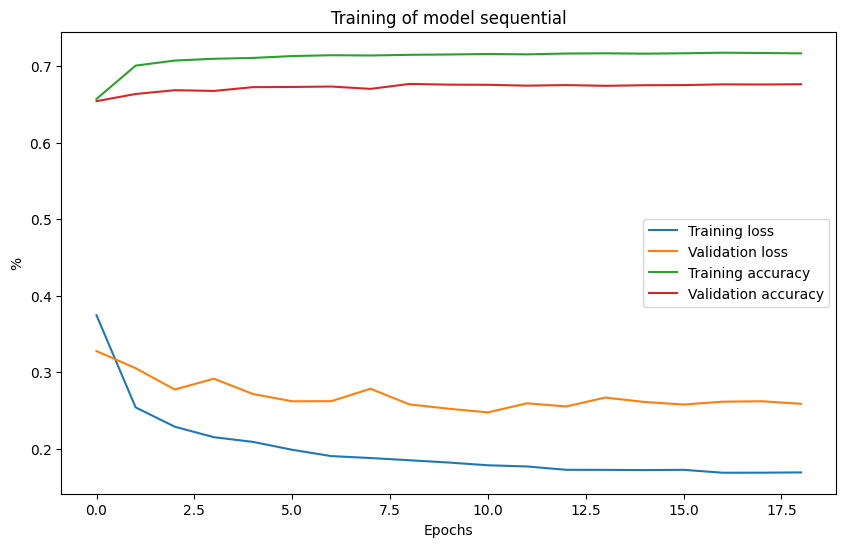

In [33]:
# Plot the training and validation loss
plot_history(history_seq, "sequential")

In [34]:
# Calculate accuracy and precision of the model
accuracy_seq, precision_seq, recall_seq, f1_seq = evaluate(X_test_wide, y_test, model_seq)
print(f"Accuracy = {accuracy_seq:.4f}, Precision = {precision_seq:.4f}, Recall = {recall_seq:.4f}, F1 Score = {f1_seq:.4f} -> sequential")

mse_seq, mae_seq, r2_seq = evaluate_continuous(X_test_wide, y_test, model_seq)
print(f"MSE = {mse_seq:.4f}, MAE = {mae_seq:.4f}, R-squared = {r2_seq:.4f} -> sequential")

155/155 [==============================] - 4s 14ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      3650
           1       0.85      0.91      0.88      1302

    accuracy                           0.93      4952
   macro avg       0.91      0.93      0.92      4952
weighted avg       0.94      0.93      0.93      4952

Accuracy = 0.9342, Precision = 0.9364, Recall = 0.9342, F1 Score = 0.9349 -> sequential
155/155 [==============================] - 2s 13ms/step
MSE = 0.0372, MAE = 0.0900, R-squared = 0.7882 -> sequential


In [35]:
# Save the model
model_seq.save(os.path.join(models_folder, f'seq/model_seq_{start_time.date()}.keras'))

Now that we have our simple and wide models covered, lets implement one last change to make this artificial network as real as possible...
* By using Bidirectional() we will allow the model to take into account the sequence of frames
* Lets also define a function to create and easily modify models

In [ ]:
# Build LSTM model
def build_model(input_shape, units):
    inputs = Input(shape=input_shape)

    # Stacked Bidirectional LSTMs
    x = inputs
    for unit in units:
        x = Bidirectional(LSTM(unit, return_sequences=True))(x)
        x = BatchNormalization()(x)
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)

    x = GlobalMaxPooling1D()(x)

    # Dense Output
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    return model

# Define model parameters
input_shape = (X_train_wide.shape[1], X_train_wide.shape[2])
lstm_units = [32, 24, 16, 12, 8]

# Build model
model_att = build_model(input_shape, lstm_units)

# Compile model
model_att.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [137]:
model_att.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 7, 12)]           0         
                                                                 
 bidirectional_81 (Bidirecti  (None, 7, 24)            2400      
 onal)                                                           
                                                                 
 batch_normalization_5 (Batc  (None, 7, 24)            96        
 hNormalization)                                                 
                                                                 
 layer_normalization_83 (Lay  (None, 7, 24)            48        
 erNormalization)                                                
                                                                 
 dropout_86 (Dropout)        (None, 7, 24)             0         
                                                           

In [138]:
# Train the model
history_att = model_att.fit(X_train_wide, y_train,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_wide, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/80
857/857 [==============================] - 49s 47ms/step - loss: 0.3279 - accuracy: 0.8534 - val_loss: 0.3126 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 2/80
857/857 [==============================] - 34s 39ms/step - loss: 0.2449 - accuracy: 0.8969 - val_loss: 0.2819 - val_accuracy: 0.6656 - lr: 0.0010
Epoch 3/80
857/857 [==============================] - 35s 41ms/step - loss: 0.2209 - accuracy: 0.9115 - val_loss: 0.2690 - val_accuracy: 0.6670 - lr: 0.0010
Epoch 4/80
857/857 [==============================] - 35s 41ms/step - loss: 0.2082 - accuracy: 0.9152 - val_loss: 0.2721 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 5/80
857/857 [==============================] - 35s 41ms/step - loss: 0.1958 - accuracy: 0.9205 - val_loss: 0.2445 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 6/80
857/857 [==============================] - 35s 41ms/step - loss: 0.1841 - accuracy: 0.9255 - val_loss: 0.2745 - val_accuracy: 0.6708 - lr: 9.0000e-04
Epoch 7/80
857/857 [==============================] - 

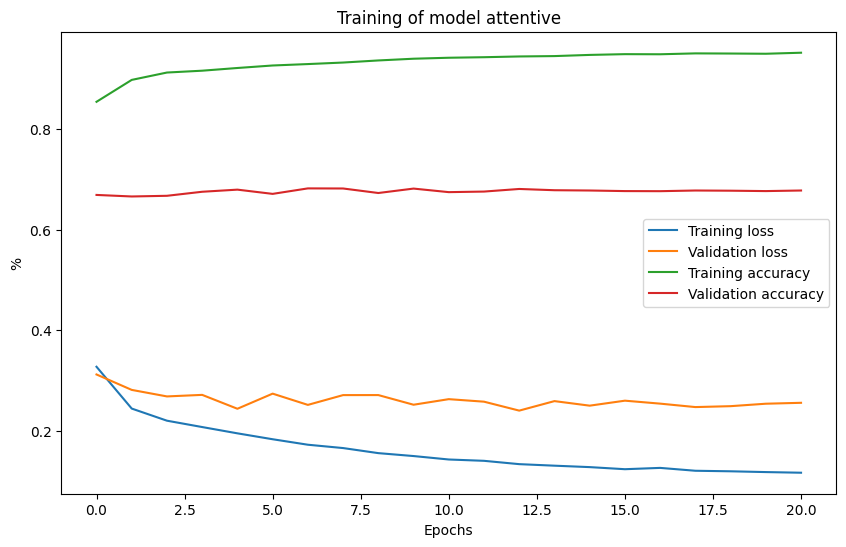

In [139]:
# Plot the training and validation loss
plot_history(history_att, "attentive")

In [140]:
# Calculate accuracy and precision of the model
accuracy_att, precision_att, recall_att, f1_att = evaluate(X_test_wide, y_test, model_att)
print(f"Accuracy = {accuracy_att:.4f}, Precision = {precision_att:.4f}, Recall = {recall_att:.4f}, F1 Score = {f1_att:.4f} -> attentive")

mse_att, mae_att, r2_att = evaluate_continuous(X_test_wide, y_test, model_att)
print(f"MSE = {mse_att:.4f}, MAE = {mae_att:.4f}, R-squared = {r2_att:.4f} -> attentive")

155/155 [==============================] - 6s 18ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3650
           1       0.85      0.90      0.88      1302

    accuracy                           0.93      4952
   macro avg       0.91      0.92      0.92      4952
weighted avg       0.94      0.93      0.93      4952

Accuracy = 0.9334, Precision = 0.9351, Recall = 0.9334, F1 Score = 0.9340 -> attentive
155/155 [==============================] - 3s 17ms/step
MSE = 0.0412, MAE = 0.0792, R-squared = 0.7658 -> attentive


In [141]:
# Save the model
model_att.save(os.path.join(models_folder, f'att/model_att_{start_time.date()}.keras'))

Lets also train a Random Forest model

In [142]:
# We train a RF model with the same data
if not make_discrete:
    y_train = (y_train > 0.5).astype(int)

# Create the Random Forest model (and set the number of estimators (decision trees))
RF_model = RandomForestClassifier(n_estimators = 24, max_depth = 12)

# Train the MultiOutputClassifier with your data
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=24)

In [143]:
# Calculate accuracy and precision of the model
accuracy_RF, precision_RF, recall_RF, f1_RF = evaluate(X_test, y_test, RF_model)
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

mse_RF, mae_RF, r2_RF = evaluate_continuous(X_test, y_test, RF_model)
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3650
           1       0.84      0.87      0.85      1302

    accuracy                           0.92      4952
   macro avg       0.90      0.90      0.90      4952
weighted avg       0.92      0.92      0.92      4952

Accuracy = 0.9227, Precision = 0.9234, Recall = 0.9227, F1 Score = 0.9230 -> RF
MSE = 0.0652, MAE = 0.0862, R-squared = 0.6292 -> RF


In [144]:
# Save the model
joblib.dump(RF_model, os.path.join(models_folder, f'RF/model_RF_{start_time.date()}.pkl'))

['C:/Users/dhers/Desktop/STORM/docs/models\\RF/model_RF_2024-11-21.pkl']

In [145]:
# Get the end time
end_time = datetime.datetime.now()

# Calculate elapsed time
elapsed_time = end_time - start_time

In [146]:
# Print the model results
print(f"Script execution time: {elapsed_time}).")

print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")
print(f"Accuracy = {accuracy_seq:.4f}, Precision = {precision_seq:.4f}, Recall = {recall_seq:.4f}, F1 Score = {f1_seq:.4f} -> sequential")
print(f"Accuracy = {accuracy_att:.4f}, Precision = {precision_att:.4f}, Recall = {recall_att:.4f}, F1 Score = {f1_att:.4f} -> attentive")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")
print(f"MSE = {mse_seq:.4f}, MAE = {mae_seq:.4f}, R-squared = {r2_seq:.4f} -> sequential")
print(f"MSE = {mse_att:.4f}, MAE = {mae_att:.4f}, R-squared = {r2_att:.4f} -> attentive")

Script execution time: 1:56:18.941563).
Evaluate model vs testing data
VS binary average
Accuracy = 0.9265, Precision = 0.9309, Recall = 0.9265, F1 Score = 0.9277 -> simple
Accuracy = 0.9283, Precision = 0.9311, Recall = 0.9283, F1 Score = 0.9292 -> wide
Accuracy = 0.9227, Precision = 0.9234, Recall = 0.9227, F1 Score = 0.9230 -> RF
Accuracy = 0.9342, Precision = 0.9364, Recall = 0.9342, F1 Score = 0.9349 -> sequential
Accuracy = 0.9334, Precision = 0.9351, Recall = 0.9334, F1 Score = 0.9340 -> attentive
VS continuous average
MSE = 0.0395, MAE = 0.1175, R-squared = 0.7753 -> simple
MSE = 0.0417, MAE = 0.0906, R-squared = 0.7625 -> wide
MSE = 0.0652, MAE = 0.0862, R-squared = 0.6292 -> RF
MSE = 0.0372, MAE = 0.0900, R-squared = 0.7882 -> sequential
MSE = 0.0412, MAE = 0.0792, R-squared = 0.7658 -> attentive


In [129]:
# Lets test the accuracy of a random and zero y_test

y_zeros = y_test - y_test

y_random = np.random.permutation(y_test)
y_random_binary = (y_random > 0.5).astype(int)

y_binary = (y_test > 0.5).astype(int)

In [130]:
# zeros
print(classification_report(y_binary, y_zeros))

accuracy_zeros = accuracy_score(y_binary, y_zeros)
precision_zeros = precision_score(y_binary, y_zeros, average = 'weighted')
recall_zeros = recall_score(y_binary, y_zeros, average = 'weighted')
f1_zeros = f1_score(y_binary, y_zeros, average = 'weighted')
print(f"Accuracy = {accuracy_zeros:.4f}, Precision = {precision_zeros:.4f}, Recall = {recall_zeros:.4f}, F1 Score = {f1_zeros:.4f} -> zeros")

mse_zeros = mean_squared_error(y_test, y_zeros)
mae_zeros = mean_absolute_error(y_test, y_zeros)
r2_zeros = r2_score(y_test, y_zeros)
print(f"MSE = {mse_zeros:.4f}, MAE = {mae_zeros:.4f}, R-squared = {r2_zeros:.4f} -> zeros")

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      3650
           1       0.00      0.00      0.00      1302

    accuracy                           0.74      4952
   macro avg       0.37      0.50      0.42      4952
weighted avg       0.54      0.74      0.63      4952

Accuracy = 0.7371, Precision = 0.5433, Recall = 0.7371, F1 Score = 0.6255 -> zeros
MSE = 0.2483, MAE = 0.2693, R-squared = -0.4126 -> zeros


c:\Users\dhers\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dhers\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dhers\anaconda3\envs\GPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dhers\anaconda3\env

In [131]:
# random
print(classification_report(y_binary, y_random_binary))

accuracy_random = accuracy_score(y_binary, y_random_binary)
precision_random = precision_score(y_binary, y_random_binary, average = 'weighted')
recall_random = recall_score(y_binary, y_random_binary, average = 'weighted')
f1_random = f1_score(y_binary, y_random_binary, average = 'weighted')
print(f"Accuracy = {accuracy_random:.4f}, Precision = {precision_random:.4f}, Recall = {recall_random:.4f}, F1 Score = {f1_random:.4f} -> random")

mse_random = mean_squared_error(y_test, y_random)
mae_random = mean_absolute_error(y_test, y_random)
r2_random = r2_score(y_test, y_random)
print(f"MSE = {mse_random:.4f}, MAE = {mae_random:.4f}, R-squared = {r2_random:.4f} -> random")

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      3650
           1       0.26      0.26      0.26      1302

    accuracy                           0.61      4952
   macro avg       0.50      0.50      0.50      4952
weighted avg       0.61      0.61      0.61      4952

Accuracy = 0.6135, Precision = 0.6135, Recall = 0.6135, F1 Score = 0.6135 -> random
MSE = 0.3500, MAE = 0.3890, R-squared = -0.9917 -> random


In [132]:
print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")
print(f"Accuracy = {accuracy_seq:.4f}, Precision = {precision_seq:.4f}, Recall = {recall_seq:.4f}, F1 Score = {f1_seq:.4f} -> sequential")
print(f"Accuracy = {accuracy_att:.4f}, Precision = {precision_att:.4f}, Recall = {recall_att:.4f}, F1 Score = {f1_att:.4f} -> attentive")
print(f"Accuracy = {accuracy_zeros:.4f}, Precision = {precision_zeros:.4f}, Recall = {recall_zeros:.4f}, F1 Score = {f1_zeros:.4f} -> zeros")
print(f"Accuracy = {accuracy_random:.4f}, Precision = {precision_random:.4f}, Recall = {recall_random:.4f}, F1 Score = {f1_random:.4f} -> random")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")
print(f"MSE = {mse_seq:.4f}, MAE = {mae_seq:.4f}, R-squared = {r2_seq:.4f} -> sequential")
print(f"MSE = {mse_att:.4f}, MAE = {mae_att:.4f}, R-squared = {r2_att:.4f} -> attentive")
print(f"MSE = {mse_zeros:.4f}, MAE = {mae_zeros:.4f}, R-squared = {r2_zeros:.4f} -> zeros")
print(f"MSE = {mse_random:.4f}, MAE = {mae_random:.4f}, R-squared = {r2_random:.4f} -> random")

Evaluate model vs testing data
VS binary average
Accuracy = 0.9265, Precision = 0.9309, Recall = 0.9265, F1 Score = 0.9277 -> simple
Accuracy = 0.9283, Precision = 0.9311, Recall = 0.9283, F1 Score = 0.9292 -> wide
Accuracy = 0.9261, Precision = 0.9262, Recall = 0.9261, F1 Score = 0.9261 -> RF
Accuracy = 0.9342, Precision = 0.9364, Recall = 0.9342, F1 Score = 0.9349 -> sequential
Accuracy = 0.9307, Precision = 0.9304, Recall = 0.9307, F1 Score = 0.9306 -> attentive
Accuracy = 0.7371, Precision = 0.5433, Recall = 0.7371, F1 Score = 0.6255 -> zeros
Accuracy = 0.6135, Precision = 0.6135, Recall = 0.6135, F1 Score = 0.6135 -> random
VS continuous average
MSE = 0.0395, MAE = 0.1175, R-squared = 0.7753 -> simple
MSE = 0.0417, MAE = 0.0906, R-squared = 0.7625 -> wide
MSE = 0.0619, MAE = 0.0829, R-squared = 0.6478 -> RF
MSE = 0.0372, MAE = 0.0900, R-squared = 0.7882 -> sequential
MSE = 0.0402, MAE = 0.0776, R-squared = 0.7710 -> attentive
MSE = 0.2483, MAE = 0.2693, R-squared = -0.4126 -> zero